In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import sawtooth, square
from IPython.display import Audio, HTML, Math, Image

In [2]:
def gen_frequency(notes): 
    """
    This function converts pitch class letter names to midi, 
    and then convert it to frequency list 

    Inputs:
    melody (string) = collection of pitch class letter names
    (Example melody: pith class letter names: 'A#4, C4, E4, D4')

    Outputs:
    The function should return a list of floats
    freq (list) = a list of frequency given a list of midi notes
    (Example output: Frquencies: [466.164, 261.626, 329.628, 293.665])
    """   

    # Set up a dictionary of pitch class with base midi note numbers
    note_freqs = {
        "C": 0, "C#": 1, "D": 2, "D#": 3, "E": 4, "F": 5, 
        "F#": 6, "G": 7, "G#": 8, "A": 9, "A#": 10, "B": 11
    }
    
    # split each pitch class as a list
    melody = notes.split(', ')
    
    # a list that will contain a list of midi notes 
    midi_list = []
    
    # converting each pitch class as a midi note and add it to midi_list
    # Each pitch class letter names are composed of two parts 
    # pitch ex) 'A#' from A#4 // octave ex) '1' from C1 
    for note in (melody):
        pitch = note[:-1]             
        octave = int(note[-1]) + 1    
        midi = (octave * 12) + note_freqs[pitch]
        midi_list.append(midi)
    
    # a list that will contain a list of frequency and midi note of A4 
    freq = []
    midi_a4 = 69 

    # convert each midi numbers into frequency using base midi note (A4) 
    freq = [round((440 * 2**((midi_note - midi_a4)/12)),3) for midi_note in midi_list]
    return freq 

In [3]:
class Oscillator:
    def __init__(self, freq=440, phase=0, amp=1, dur=2, fs=44100):
        """
        Inputs:
        freq (float) = frequency of the sinusoid in Hz
        phase (float) = initial phase of the sinusoid in radians
        amp (float) = amplitude of the sinusoid
        dur (float) = duration of the sinusoid (in seconds)
        fs (float) = sampling frequency of the sinusoid in Hz
        """
        self.freq = freq
        self.phase = phase
        self.amp = amp
        self.dur = dur
        self.fs = fs
        self.t = np.arange(0, self.dur,1/self.fs) # The array of zeros with the length of given duration 


    def sineGen(self, t):
        # Output: The function returns a numpy array of generated sinusoid (use np.sin())
        return np.sin(2*np.pi*self.freq*self.t)
        

    def squareGen(self):
        # Output: The function returns a numpy array of the periodic square waveform 
        return square(self.sineGen())
    
    def sawtoothGen(self):
        # Calculate the sawtooth wave using the modulo operator
        sawtooth_wave = (2 * self.amp / np.pi) * np.arctan(np.tan(np.pi * self.freq * self.t + self.phase))
        return sawtooth_wave

    def triangleGen(self):
        triangle_wave = (2 * self.amp / np.pi) * np.abs(self.sawtoothGen())
        return triangle_wave

    def harmonicSumWaves(self, amps, freqs):
        t = np.linspace(0, self.dur, int(self.dur * fs), False)
        waves = []
        for amp, freq in zip(amps, freqs):
            wave = amp * np.sin(2*np.pi*freq*t)
            waves.append(wave)
        return self.amp * np.sum(waves, axis=0)


In [4]:
class Envelope:
    def __init__(self,dur=2,fs=44100):
        """
        Inputs:
        dur (float) = duration in seconds
        fs (float) = sampling frequency of the signal in Hz
        """
        self.dur = dur
        self.fs = fs
    
    
    def adsr(self, attack=0.2, decay=0.2, release=0.3, susL=0.8):
        """
        Inputs:
        attack (float) = portion of attack phase within an audio
        decay (float) = portion of decay phase within an audio
        release (float) = portion of release phase within an audio
        susL (float) = sustain level  
        
        Output:
        The function should return a numpy array
        """
        # time from 0 to given duration seconds with fs=44100
        t = np.zeros(self.dur*self.fs)

        # calculate durations of attack, decay, sustain, and release phases 
        # for a given total length of an audio file
        a = int(t.size * attack)
        d = int(t.size * decay)
        r = int(t.size * release)
        sus_dur = int(t.size-a-d-r)

        # creates an np ndarray of adsr envelope
        t[0:a]= np.linspace(0, 1, a)
        t[a:a+d]=np.linspace(1, susL, d)
        t[a+d:t.size-r] = np.full(sus_dur, susL)
        t[t.size-r:t.size] = np.linspace(susL, 0, r)
        return t

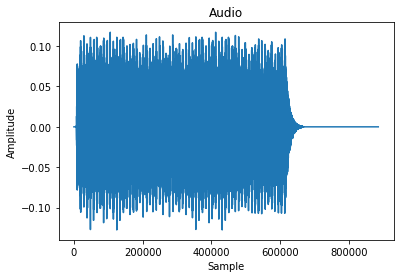

In [9]:
#demo 1: low delay, AM synth
# define the pitch classes you want to use
freqs = gen_frequency("C3, D#4, G3, A#3, C3, D#4, G4, A#4, C3, D#4, G3, A#3, C3, D#4, G4, A#4, D2, F4, A3, C4, D2, F4, A4, C5, D2, F4, A3, C4, D2, F4, A4, C5, C3, D#4, G3, A#3, C3, D#4, G4, A#4, C3, D#4, G3, A#3, C3, D#4, G4, A#4, A#1, D4, F3, A3, A#1, D4, F4, A4, A#1, D4, F3, A3, A#1, D4, F4, A4")

# define the duration, amplitude, and sampling rate of the oscillators
dur = 5
amp = 0.1
fs = 44100


# create a list of Oscillator objects for each frequency
oscs = [Oscillator(freq=freq, dur=dur, amp=amp) for freq in freqs]

# generate amplitude arrays for each note using a loop, increase/decrease harmonic count for change of timbre
n_harmonics = 5
amps = []
for i, osc in enumerate(oscs):
    note_amps = []
    for j in range(n_harmonics):
        amp = 1 / (j + 1)
        note_amps.append(amp)
    amps.append(note_amps)

# generate sine waves for each note using additive synthesis
sine_waves = [osc.harmonicSumWaves(note_amps, [osc.freq * (h + 1) for h in range(n_harmonics)]) for osc, note_amps in zip(oscs, amps)]
# create an envelope with an ADSR shape
env = Envelope(dur=dur)
adsr = env.adsr(attack=0.01, decay=0.05, susL=0.0, release=0.0)

# apply the ADSR envelope to each sine wave
sine_waves_adsr = [sine_wave * adsr for sine_wave in sine_waves]

# apply the delay effect with a 0.1675 second delay, 0.5 feedback, and a 10 second decay time
delay_time = 0.1675 
feedback = 0.5
decay_time = 10.0
delayed_waves = []

for sine_wave_adsr in sine_waves_adsr:
    delayed_wave = np.zeros(len(sine_wave_adsr) + int(delay_time * fs * 7))
    for i in range(7):
        delayed_samples = int(delay_time * fs * (i + 1))
        delayed_wave[delayed_samples:delayed_samples + len(sine_wave_adsr)] += sine_wave_adsr * feedback ** (i + 1)
    delayed_waves.append(delayed_wave)
    

# write each delayed wave to a separate file
for i, delayed_wave in enumerate(delayed_waves):
    filename = f"singleNoteDelayed{i}.wav"
    write(filename, fs, delayed_wave)

# read in each delayed wave file
signals = []
for i in range(len(freqs)):
    filename = f"singleNoteDelayed{i}.wav"
    fs, signal = read(filename)
    signals.append(signal)

# combine the signals with overlap
overlap_len = int(fs/4.6)  # overlap time
combined_signal = np.zeros(len(signals[0]) + len(signals) * overlap_len)
for i, signal in enumerate(signals):
    combined_signal[i * overlap_len:i * overlap_len + len(signal)] += signal

# write the combined signal to a new wav file
write("combinedDelayed.wav", fs, combined_signal)
plt.plot(combined_signal)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Audio")
plt.show()
# play the combined signal
Audio(combined_signal, rate=44100)


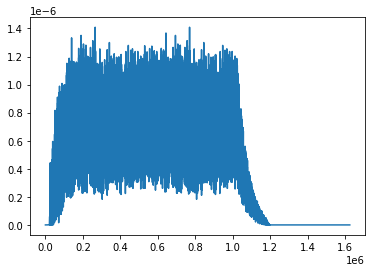

In [10]:
#demo 2: high delay, triangle wave
# define the pitch classes you want to use
freqs = gen_frequency("C4, D#4, G4, A4, A#4, D5, A#4, A4, G4, D#4, C4, D#4, G4, A4, A#4, D5, A#4, A4, G4, D#4, G3, A#3, D4, D#4, G4, A4, F4, D#4, D4, A#3, G3, A#3, D4, D#4, G4, A4, F4, D#4, D4, A#3, C4, D#4, G4, A4, A#4, D5, A#4, A4, G4, D#4, C4, D#4, G4, A4, A#4, D5, A#4, A4, G4, D#4, G3, A#3, D4, D#4, G4, A4, F4, D#4, D4, A#3, G3, A#3, D4, D#4, G4, A4, F4, D#4, D4, A#3")

# define the duration, amplitude, and sampling rate of the oscillators
dur = 10
amp = 0.001
fs = 44100


# create a list of Oscillator objects for each frequency
oscs = [Oscillator(freq=freq, dur=dur, amp=amp) for freq in freqs]

# generate sine waves for each note
sine_waves = [osc.triangleGen() for osc in oscs]

# create an envelope with an ADSR shape
env = Envelope(dur=dur)
adsr = env.adsr(attack=0.01, decay=0.05, susL=0.0, release=0.0)

# apply the ADSR envelope to each sine wave
sine_waves_adsr = [sine_wave * adsr for sine_wave in sine_waves]

# apply the delay effect with a 0.5 second delay, 0.7 feedback, and a 1 second decay time with 6 delays per note
delay_time = 0.5
feedback = 0.7
decay_time = 1.0
delayed_waves = []
per_note = 8
for sine_wave_adsr in sine_waves_adsr:
    delayed_wave = np.zeros(len(sine_wave_adsr) + int(delay_time * fs * per_note))
    for i in range(per_note):
        delayed_samples = int(delay_time * fs * (i + 1))
        delayed_wave[delayed_samples:delayed_samples + len(sine_wave_adsr)] += sine_wave_adsr * feedback ** (i + 1)
    delayed_waves.append(delayed_wave)

# write each delayed wave to a separate file
for i, delayed_wave in enumerate(delayed_waves):
    filename = f"singleNoteDelayed{i}.wav"
    write(filename, fs, delayed_wave)

# read in each delayed wave file
signals = []
for i in range(len(freqs)):
    filename = f"singleNoteDelayed{i}.wav"
    fs, signal = read(filename)
    signals.append(signal)

# combine the signals with overlap
overlap_len = int(fs/3.5)  
combined_signal = np.zeros(len(signals[0]) + len(signals) * overlap_len)
for i, signal in enumerate(signals):
    combined_signal[i * overlap_len:i * overlap_len + len(signal)] += signal

# write the combined signal to a new wav file
write("combinedDelayed.wav", fs, combined_signal)

# display the waveform of the combined signal


# plot the signal
plt.plot(combined_signal)
plt.show()
Audio(combined_signal, rate=44100)